# Proyecto 4: Procesamiento del Lenguaje Natural. 

# Informe final de la Carrera

Por Vanesa Flores. Link en [GitHub](https://github.com/vanesa0894/NLP_Redes_Neuronales_Proyecto4).

El presente informe está desarrollado en base a lo obtenido en el Proyecto 3, el cual puede ser visto [aquí](https://github.com/vanesa0894/Procesamiento_del_Lenguaje_Natural_NLP_Proyecto3). En dicho proyecto se muestra de forma ordenada el Análisis Exploratorio de los datos, el proceso de normalización y limpieza de los mismos, y por último el entrenamiento de distintos modelos de aprendizaje automático en búsqueda de los mejores resultados para clasificación de texto de múltiples clases y clasificación binaria.

## Objetivo

Implementar alguna nueva metodología que permita complementar o mejorar el problema de asignar la cantidad de estrellas correspondientes a la crítica de un producto generada por un usuario, partiendo de lo desarrollado en el proyecto anterior. 

## Planteamiento

Basándonos en el objetivo, se plantea aplicar herramientas del aprendizaje profundo con el fin de optimizar la predicción de las estrellas asiganadas a un comentario. Se trabajará con redes neuronales artificiales, tanto para el problema de clasificación de texto para múltiples clases (1-5 estrellas) como para el problema binario planteado al final del proyecto 3 (positiva-negativa). 

## Recursos

### Dataset Original: The Multilingual Amazon Reviews Corpus

Como complemento, dejamos a su disposición dónde puede encontrar el dataset original [aquí](https://github.com/kang205/SASRec) y su [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt).

Este conjunto de datos contiene comentarios en español, recopiladas entre el 1 de noviembre de 2015 y el 1 de noviembre de 2019. Y además, presenta las siguientes características:

- `review_id`: ID del comentario.
- `product_id`: ID del producto.
- `reviewer_id`: ID de un revisor.
- `stars`: número de estrellas asignadas al comentario.
- `review_body`: texto del comentario.
- `review_title`: título del comentario.
- `language`: idioma del comentario.
- `product_category`: categoría general del producto.

### Dataset Normalizado

Utilizaremos en el desarrollo de este informe, un dataset generado en el proyecto anterior, el cual ya está normalizado y limpio. Lo puedes encontrar [aquí](https://drive.google.com/drive/folders/1jwfhyozoOFDtoIm5tPDli-YWjrshcliV?usp=sharing). Sus características:

- `stars`: número de estrellas asignadas al comentario.
- `total_review`: representa el texto concatenado de las atributos `review_body` y `review_title`.
- `review_tokens`: tokens generados a partir de total_review.
- `reviews_stemm`: stems generados a través del algoritmo de Snowball de la librería `NLKT`.
- `reviews_lemma`: lemmas generados con la librería `Stanza` para texto en español. 

### Nuevas librerías: TensorFlow y Keras

Se trabajará con dos nuevas librerías, `TensorFlow` y `Keras`. Éstas nos permiten trabajar con herramientas de apredizaje profundo de una forma amigable y con gran rapidez. Principalmente, importaremos TensorFlow y trabajaremos con la API de Keras de ésta librería. Su documentación la puedes encontrar [aquí](https://www.tensorflow.org/guide/keras?hl=es-419).


### Librerías Útiles

In [1]:
import gc

import numpy as np
from numpy.random import seed

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from keras.models import Sequential
from plot_keras_history import plot_history
from keras.regularizers import l2
from keras.backend import clear_session

Defino una semilla para obtener resultados reproducibles. [Ref](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)

In [2]:
my_seed = 42
seed(my_seed)
tf.random.set_seed(my_seed)

# Carga de datos

Cargamos el dataset normalizado:

In [3]:
data = pd.read_csv('dataset_clean.csv')
data.head()

,Unnamed: 0,stars,total_review,review_tokens,reviews_stemm,review_tokens_unidos,reviews_lemma
0,0,1,nada bueno se me fue ka pantalla en menos de 8...,"['nada', 'bueno', 'pantalla', 'menos', 'recibi...",nad buen pantall men recib respuest fabric tel...,nada bueno pantalla menos recibido respuesta f...,nada buen pantalla menos recibido respuesta fa...
1,1,1,"horrible, nos tuvimos que comprar otro porque ...","['horrible', 'comprar', 'sabemos', 'ingles', '...",horribl compr sab ingles informat despu hor ca...,horrible comprar sabemos ingles informatico de...,horrible comprar saber ingle informatico despu...
2,2,1,te obligan a comprar dos unidades y te llega s...,"['obligan', 'comprar', 'unidades', 'llega', 's...",oblig compr unidad lleg sol form reclam autent...,obligan comprar unidades llega solo forma recl...,obligar comprar unidad llegar solo forma recla...
3,3,1,"no entro en descalificar al vendedor, solo pue...","['entro', 'descalificar', 'vendedor', 'solo', ...",entro descalific vendedor sol pued dec tras es...,entro descalificar vendedor solo puedo decir t...,entrar descalificar vendedor solo poder decir ...
4,4,1,llega tarde y co la talla equivocada devuelto,"['llega', 'tarde', 'talla', 'equivocada', 'dev...",lleg tard tall equivoc devuelt,llega tarde talla equivocada devuelto,llegar tarde talla equivocado devolver


In [4]:
#Dimensión del dataset
print('Dimensión del dataset:' , data.shape)
#Valores Faltantes
data.isna().sum()

Dimensión del dataset: (210000, 7)


Unnamed: 0              0
stars                   0
total_review            0
review_tokens           0
reviews_stemm           0
review_tokens_unidos    0
reviews_lemma           0
dtype: int64

Tenemos un total de 210.000 instancias sin presencia de datos faltantes. 

### Observaciones:

En lo que sigue, para realizar una comparación coherente entre los resultados obtenidos en el proyecto anterior y el actual, consideraremos lo siguiente:

- Trabajar con los datos que han sido generados a través del proceso de lemmatización. Por lo que nuestra variable independiente será `reviews_lemma` y nuestra variable dependiente `stars`; nuestra variable a predecir.

- Transformar nuestros datos en entidades numéricas haciendo uso de la técnica de vectorización`TF-IDF`. 

In [5]:
# Variables relevantes
dataset = data[['stars','reviews_lemma']]
dataset.head()

,stars,reviews_lemma
0,1,nada buen pantalla menos recibido respuesta fa...
1,1,horrible comprar saber ingle informatico despu...
2,1,obligar comprar unidad llegar solo forma recla...
3,1,entrar descalificar vendedor solo poder decir ...
4,1,llegar tarde talla equivocado devolver


# Vectorización

Como ya se ha mencionado se transformarán los datos haciendo uso del módulo `TfidfVectorizer` de la librería `sklearn`. Se puede destacar también, que existe un módulo de TensorFlow que nos permite generar vectores numéricos a partir de un texto, lo puedes ver [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization). Sin embargo, para poder cotejar los resultados obtenidos en las dos iteraciones del proyecto, se decide utilizar el TF-IDF. 

# Métricas

Para justificar el desempeño de nuestros modelos se elije como métrica el `accuracy` ya que contamos con un dataset cuyas clases están perfectamente balanceadas. Entonces, calcularemos del total de los comentarios cuántos han sido clasificados en la clase correcta, y esto nos bastará para saber si el modelo está clasificando bien o no. Utilizaremos la clase `accuracy_score` de la librería `sklearn` para calcularlo y, para visualizar la clasificación por estrellas utilizaremos la clase `confusion_matrix`. 

In [6]:
def confusion(y_test,y_pred):
    names=['Una','Dos','Tres','Cuatro','Cinco']
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

def confusion_bin(y_test,y_pred):
    names=['Negativo','Positivo']
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(2,2))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

# Modelo base (benchmark)

Como modelo de partida, utilizaremos el modelo que nos generó mejor desempeño en el proyecto anterior. 

Entrenaremos un modelo de regresión logística, con los hiperparámetros obtenidos en la optimización del mismo:

[ `C`= 1, `max_iter`= 1000, `multi_class`= 'multinomial', `penalty`= 'l2', `random_state`=42 ]

Los parámetros para la vectorización son los que presentaron el ajuste ideal del modelo:

[ `max_features`= 1000, `ngram_range` = (1,2)]

In [7]:
# Vectorización
vectorizer = TfidfVectorizer(max_features= 1000, ngram_range = (1,2))
X = vectorizer.fit_transform(dataset['reviews_lemma']).toarray()
y = dataset.stars
print(X.shape)
print(y.shape)

(210000, 1000)
(210000,)


Generamos los conjuntos de entrenamiento y testeo, con una proporción de los datos del 70% y 30% respectivamente. Para ésto, se hace uso de la función `train_test_split` para tener independencia en la partición de los datos. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=dataset.stars, random_state=my_seed)

0.5271269841269841


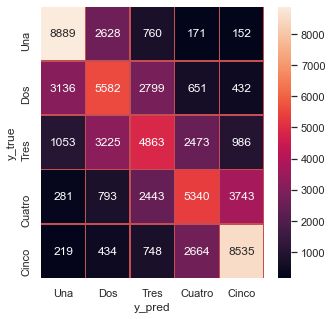

In [9]:
#Ajustamos y evaluamos el modelo benchmark
lr = LogisticRegression(C= 1, max_iter= 1000, multi_class= 'multinomial', penalty= 'l2', random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
confusion(y_test,y_pred)

Obtenemos una efectividad en la predicción de un 0.527, presenciando mejor oportunidad de clasificación para las estrellas 1 y 5 que puntúan los comentarios más negativos o positivos sobre los productos. Además, las críticas correspondientes a las estrellas 2,3,4 presentan mayor dificultad de predicción. Ésto se debe a la subjetividad con la que un usuario puede generar un comentario y adicionalmente, asignarle una estrella.  

# Redes Neuronales

En lo que sigue, implementaremos modelos de aprendizaje profundo con la intención de encontrar mejores resultados para la predicción de estrellas. Antes de esto, se definirán algunos conceptos importantes:

**Red Neuronal Artificial**: es un modelo de aprendizaje automático profundo con características similares al comportamiento de una red neuronal humana. Estas redes contienen nodos, como las neuronas en nuestro cerebro, que están interconectados entre sí siguiendo una estructura ordenada. Presentan una estructura en capas, dónde cada capa tiene funciones a desarrollar.

**Capa de entrada**: está formada por nuestros datos de entrada, las características con las cuales la red será capaz de aprender.

**Capas ocultas**: pueden existir varias capas ocultas. Acá es donde la red realiza diferentes cálculos y ajustes para arrojar los mejores resultados.

**Capa de salida**: presenta los resultados obtenidos luego del entrenamiento.

El número de capas de la red neuronal es un parámetro a definir. Al igual que número de neuronas que contiene cada capa.

**Función de activación**: en las capas ocultas se realizan una serie de cálculos que involucran pesos y sesgos generados, en principio, de forma aleatoria y luego van siendo ajustados durante el entrenamiento. La función de activación devuelve una salida que es generada por la neurona dada una entrada o un conjunto de entradas. Existen diversos tipos de función de activación y, dependiendo de sus características conviene o no usarlas.

En este desarrollo, utilizaremos 3 tipos de función de activación:

* **Función RELU**: permite el aprendizaje rápido en las redes neuronales. Si se le pasa un valor negativo asigna un cero, y si no, queda igual si el valor es positivo.
* **Función Softmax**: se usa para clasificar datos con múltiples clases. Asigna probabilidades de pertenencia de cada clase. Ésta función la usaremos para la clasificación de 1 a 5 estrellas.
* **Función Sigmoide**: se usa para clasificar datos con etiquetas binarias. La usaremos para el caso de comentarios negativos y positivos. 

**Optimizador**: es el encargado de generar pesos que presenten cada vez errores más pequeños. Usaremos en nuestro caso, el descenso por gradiente para disminuir la brecha de error entre los resultados calculados y los deseados.

**Función de pérdida**: nos permite calcular diferencia de error entre los resultados calculados y los deseados.

**Métrica**: nos indicará qué tan buenos son nuestros resultados.

## Parámetros del modelo

Configuraremos el modelo con los siguientes parámetros:

`modelo`: Sequential(), nos permite crear un modelo con una serie de capas de manera secuencial.

`número de capas`: Se trabajará con 6 capas, una de entrada, cuatro ocultas y una de salida. Se consideró crear la red con 6 capas, luego de varias iteraciones se encontraron mejores resultados. 

`input_dim`: la dimensión de las características de entrada es igual a la cantidad de atributos generados por el vectorizador.

`units`: la cantidad de neuronas por capas son 2000, 1000, 500, 100, 50 y 6, para el caso de múltiples clases. Para el caso binario cambiaremos la última capa a 2 salidas.

`activation`: 'relu' para las primeras 5 capas y 'softmax' para la útlima.

`kernel_regularizer`: usamos un regularizador que permita penalizar los parámetros de la capa durante la optimización y con ésto obtener mejores resultados. Se escoge la regularización de Ridge L2, con un alpha igual 0.001.

`loss`: 'sparse_categorical_crossentropy', se escoge ésta función de pérdida porque es la sugerida para múltiples clases. [ref](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

`optimizer`: 'sgd', se escoge descenso por gradiente ya que arrojó mejor performance que el optimizador 'adam'. 

`metrics`: 'accuracy', ya que el las etiquetas están balanceadas. 

Para el ajuste del modelo:

`epochs`: 50, se escoge 50 épocas con la intención de observar el desempeño del conjunto de entrenamiento y testeo. De estar sobreajustado o no, se considerará modificar este parámetro. Representa la cantidad de iteraciones a realizar por el algoritmo. 

`batch_size`: El tamaño del lote lo escogemos igual a 100. Con esto alimentamos a la red con muestras más pequeñas que el conjunto de muestra original. 


### Definimos el modelo

Primero, vamos a considerar incrementar el número de características generadas por el vectorizador TF-IDF. Ésto se decide después de realizar varias iteraciones con diferentes valores máximos de features. Entonces, lo incrementaremos a 2000 y generaremos de nuevo los conjustos de train y test.

In [7]:
vectorizer = TfidfVectorizer(max_features= 2000, ngram_range = (1,2))
X = vectorizer.fit_transform(dataset['reviews_lemma']).toarray()
y = dataset.stars
print(X.shape)
print(y.shape)

(210000, 2000)
(210000,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=dataset.stars, random_state=my_seed)

Vamos a configurar la red a partir de los parámetros elejidos anteriormente: 

In [12]:
max_features = 2000  # Número máximo de características generadas

model = Sequential()
model.add(layers.Dense(units=2000, input_dim=max_features, activation='relu'))
model.add(layers.Dense(units=1000, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001)))
model.add(layers.Dense(units=500, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001)))
model.add(layers.Dense(units=100, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001)))
model.add(layers.Dense(units=50, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001)))
model.add(layers.Dense(6, activation='softmax'))

Utilizamos el método `compile()` para configurar el modelo para el entrenamiento y observamos el resúmen con las características de la red neuronal definida. 

In [13]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              4002000   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 6,558,956
Trainable params: 6,558,956
Non-trainable params: 0
______________________________________________

Entrenamos el modelo con el método `fit()`. Indicando el número de épocas, tamaño del lote y conjuntos de entrenamiento y testeo.

In [14]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100).history

Calculamos el desempeño del modelo. Es importante tener en cuenta que, el mejor desempeño lo obtendremos cuando la pérdida tienda a cero y el accuracy tienda a 1.  

In [15]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Loss: {:.4f}".format(loss))
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Loss: {:.4f}".format(loss))
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Loss: 0.9817
Training Accuracy: 0.6648
Testing Loss: 1.2474
Testing Accuracy:  0.5319


Obtenemos un accuracy de 0.5319, siendo éste mayor que el obtenido en nuestro modelo benchmark; y una pérdida de 1.2474. Veamos entonces cómo varía la pérdida y la precisión del modelo según el número de épocas. Para ésto utilizaremos el módulo `plot_history`, que nos mostrará el desempeño del modelo para los conjuntos de entrenamiento y testeo. 

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

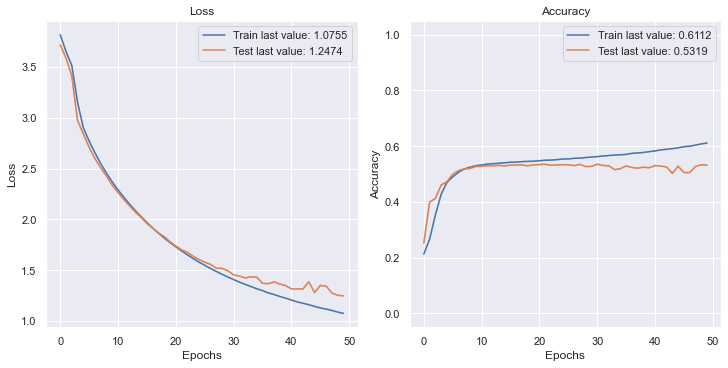

In [16]:
plot_history(history)

Se observa que a partir de la época 25 se empieza a notar una brecha más amplia entre el desempeño de los conjuntos de entrenamiento y testeo, lo cual indica que el modelo empieza a sobreajustarse. Escogemos entonces, entrenar nuevamente el modelo pero con 28 épocas. 

In [13]:
clear_session()

In [9]:
max_features = 2000  

model1 = Sequential()
model1.add(layers.Dense(2000, input_dim=max_features, activation='relu'))
model1.add(layers.Dense(1000, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(layers.Dense(500, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(layers.Dense(100, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(layers.Dense(50, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model1.add(layers.Dense(6, activation='softmax'))

model1.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

history = model1.fit(X_train, y_train,
                    epochs=28,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100).history

loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
print("Training Loss: {:.4f}".format(loss))
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Testing Loss: {:.4f}".format(loss))
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Loss: 1.4599
Training Accuracy: 0.5662
Testing Loss: 1.5206
Testing Accuracy:  0.5348


Se obtiene un mejor desempeño general del modelo en comparación al modelo con 50 épocas y al modelo benchmark planteado, sin embargo, la pérdida obtenida es un poco más alta.

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

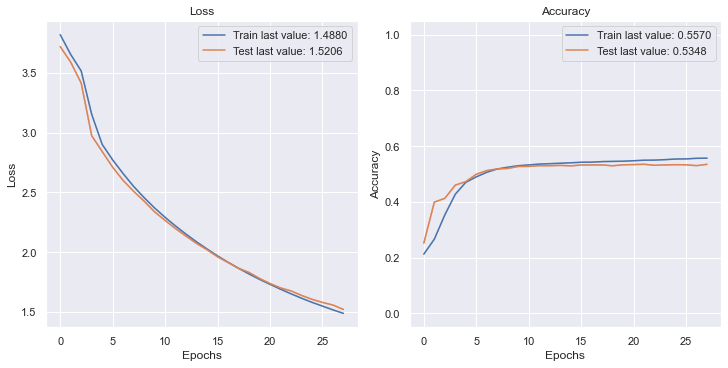

In [10]:
plot_history(history)

Nos encontramos con dos gráficos que presentan comportamiento esperado. La pérdida disminuye al incrementar el número de iteraciones, mientras que el accuracy aumenta. 

Ahora, vamos a calcular las predicciones haciendo uso del método `predict_classes()`.

In [11]:
y_pred = model1.predict_classes(X_test)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([2, 2, 3, ..., 5, 4, 5], dtype=int64)

Observamos que se genera un arreglo con las cantidad de estrellas predichas para los comentarios del conjunto de testeo.

Por último observemos cómo es la clasificación por clases mediante la matríz de confusión:

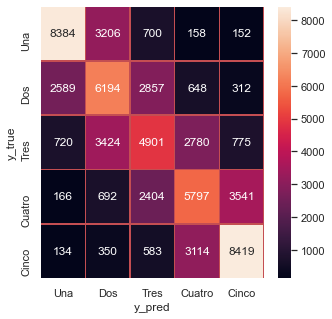

In [12]:
confusion(y_test,y_pred)

Tenemos una clasificación con un comportamiento similar al obtenido en el modelo benchmark, donde se clasifican mejor las clases extremo, la 1 y 5. Sin embargo, es importante destacar que éste modelo predice mucho mejor las clases intermedias, 2,3 y 4, que presentaban mayores problemas de clasificación en los modelos antes desarrollados. 

In [22]:
clear_session()
gc.collect()

7788

Ahora, tal como se planteó al inicio, entrenaremos un nuevo modelo para el caso binario con etiquetas positivas y negativas. 

# Modelo Binario

Para entrenar un modelo binario con dos etiquetas, positivas y negativas, vamos a hacer uso del dataset original con las variables de interés.

In [23]:
dataset.head()

,stars,reviews_lemma
0,1,nada buen pantalla menos recibido respuesta fa...
1,1,horrible comprar saber ingle informatico despu...
2,1,obligar comprar unidad llegar solo forma recla...
3,1,entrar descalificar vendedor solo poder decir ...
4,1,llegar tarde talla equivocado devolver


Creamos un nuevo dataset que contenga las dos nuevas etiquetas generadas. Se decide tomar como etiqueta negativa aquellos comentarios que tengan asignados 1 y 2 estrellas, y como etiqueta positivas los que tengan 3, 4 y 5 estrellas. Además asignaremos un valor numérico a cada etiqueta, 0 para las negativas y 1 para las positivas.

In [24]:
ds_binario = dataset.sort_values('stars')
ds_binario.head() 

,stars,reviews_lemma
0,1,nada buen pantalla menos recibido respuesta fa...
27996,1,bateria fallar duro nada carga poder ser desga...
27997,1,borrado dibujo vaso estafa compra comprear
27998,1,gran cosa apariencia mucho bien luego tinto ju...
27999,1,comprar funda samsung funda bien movil borde r...


In [25]:
def set_values(row, value):
    return value[row]
   
map_dictionary ={1 : 0, 2 : 0, 3 : 1, 4 :1, 5:1} 
   
ds_binario['etiqueta'] = ds_binario['stars'].apply(set_values, args =(map_dictionary, )) 
ds_binario.reset_index(drop=True, inplace=True)
ds_binario.head()

,stars,reviews_lemma,etiqueta
0,1,nada buen pantalla menos recibido respuesta fa...,0
1,1,bateria fallar duro nada carga poder ser desga...,0
2,1,borrado dibujo vaso estafa compra comprear,0
3,1,gran cosa apariencia mucho bien luego tinto ju...,0
4,1,comprar funda samsung funda bien movil borde r...,0


Veamos cómo es la distribución de las nuevas etiquetas generadas:

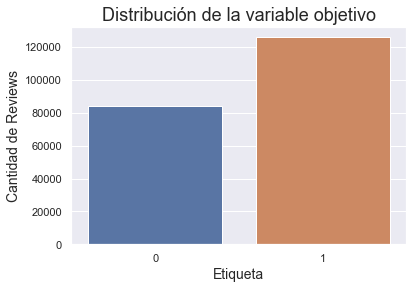

In [26]:
sns.countplot(data=ds_binario, x=ds_binario.etiqueta)
plt.title('Distribución de la variable objetivo', fontsize=18)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Reviews', fontsize=14)
plt.show()

Se observa que existe un desbalance en las clases a predecir. La clase negativa representa un 40% del total de los datos, mientras que la clase positica representa el 60%. Se conoce que el problema con el desequilibrio de clases genera cierto sesgo en los resultados obtenidos. Sin embargo, se ha encontrado una referencia donde se manifiestan diferentes tipos de desbalance:

"**Slight Imbalance**: An imbalanced classification problem where the distribution of examples is uneven by a small amount in the training dataset (e.g. 4:6).

**Severe Imbalance**: An imbalanced classification problem where the distribution of examples is uneven by a large amount in the training dataset (e.g. 1:100 or more)" [Ref](https://machinelearningmastery.com/what-is-imbalanced-classification/)

Por lo que en nuestro caso, estaríamos en presencia de un desbalance ligero.

Entonces, basandonos en lo expuesto y la referencia citada, continuamos el proyecto con las clases tal como fueron generadas. 

Ahora bien, vamos a entrenar el modelo. Para esto, consideraremos definir una red neuronal con las mismas características a la usada en el caso de múltiples clases, destacando las siguientes diferencias:

**Función de activación**: usaremos la `función sigmoide`, que por referencias presenta mejores resultados para clasificaciones binarias.

**Función de pérdida**: configuraremos la pérdida con la función `binary_crossentropy`, también ideal para el caso binario. 

Empecemos transformando los datos a entidades numéricas y luego, generando los conjuntos de entrenamiesto y testeo:

In [27]:
vectorizer = TfidfVectorizer(max_features= 2000, ngram_range = (1,2))
X = vectorizer.fit_transform(ds_binario['reviews_lemma']).toarray()
y = ds_binario.etiqueta
print(X.shape)
print(y.shape)

(210000, 2000)
(210000,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=dataset.stars, random_state=my_seed)

Configuremos nuestra red neuronal. Empezaremos el entrenamiento con 50 épocas y un tamaño de lote de 100 muestras. 

In [29]:
max_features = 2000  

model2 = Sequential()
model2.add(layers.Dense(2000, input_dim=max_features, activation='relu'))
model2.add(layers.Dense(1000, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(layers.Dense(500, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(layers.Dense(100, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(layers.Dense(50, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

history = model2.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100).history

loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Loss: {:.4f}".format(loss))
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Loss: {:.4f}".format(loss))
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Loss: 0.2886
Training Accuracy: 0.9597
Testing Loss: 0.5475
Testing Accuracy:  0.8317


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

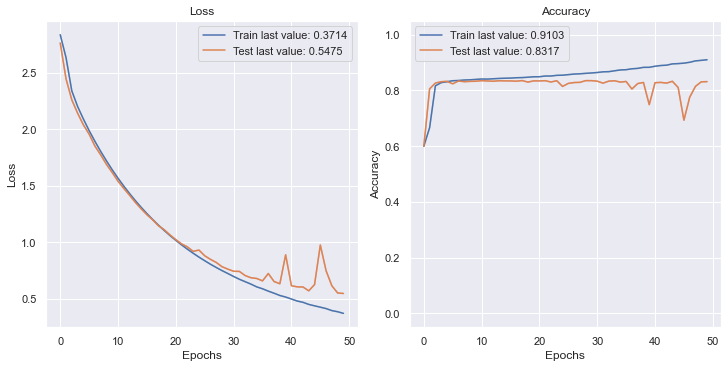

In [30]:
plot_history(history)

In [31]:
clear_session()
gc.collect()

10651

Nos encontramos con un modelo sobreajustado después de la época 20, con diferencia entre el desempeño del conjunto de entrenamiento y testeo de casi 10 puntos. Por tanto, se decide entrenar nuevamente el modelo ajustanto éste parámetro a 20 épocas. 

In [32]:
max_features = 2000  

model3 = Sequential()
model3.add(layers.Dense(2000, input_dim=max_features, activation='relu'))
model3.add(layers.Dense(1000, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(500, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(100, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(50, input_dim=max_features, activation='relu', kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

history = model3.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100).history

loss, accuracy = model3.evaluate(X_train, y_train, verbose=False)
print("Training Loss: {:.4f}".format(loss))
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Loss: {:.4f}".format(loss))
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Loss: 1.0339
Training Accuracy: 0.8525
Testing Loss: 1.0667
Testing Accuracy:  0.8330


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

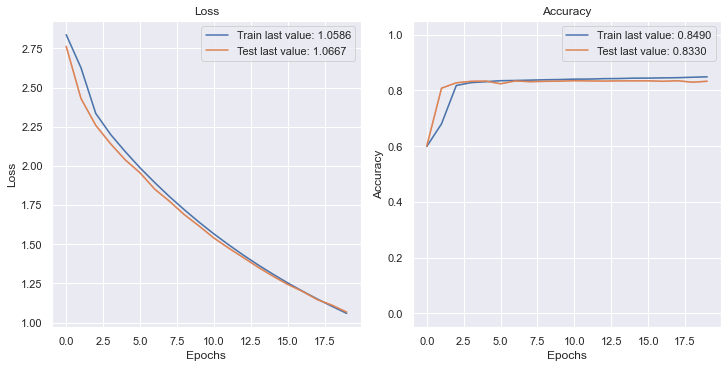

In [33]:
plot_history(history)

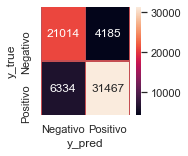

In [34]:
y_pred = model3.predict_classes(X_test)
confusion_bin(y_test,y_pred)

In [35]:
clear_session()
gc.collect()

10073

En el proyecto anterior se alcanzó un desempeño para el caso binario de 0.823, por lo que este modelo con redes neuronales presenta una mejora con un accuracy de 0.8330. Es importante destacar que hemos decido entrenar el modelo con clases desbalanceadas, por lo que los resultados podrían presentar un poco de sesgo y por tanto, no ser significativa la diferencia de entrenar un modelo de regresión logística que si asigne pesos a las clases desbalanceadas, que entrenar un modelo de red neuronal con clases desbalanceadas. 

Observaciones finales:

* Partiendo del objetivo planteado, hemos logrado implementar una nueva técnica para modelar nuestros datos y obtener además, mejores resultados en la clasificación de las clases, tanto para el modelo de múltiples clases como para el modelo binario. 

* Es posible que, como fue planteado en el proyecto anterior, se obtengan mejores resultados haciendo otro proceso de normalización de los datos y considerando otro tipo vectorización de los mismos. 

* Existe también la posibilidad de hacer uso de redes neuronales pre-entrenadas como la desarrollada por Google, [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270), para el mejoramiento de la clasificación de texto. En el caso de español se ha encontrado un modelo entrenado a partir de BERT llamado [BETO](https://www.ibidemgroup.com/edu/traduccion-automatica-bert-beto/) que podría funcionar bastante bien para este proyecto. 

### Referencias

https://www.deeplearningbook.org/

https://www.tensorflow.org/

https://velascoluis.medium.com/optimizadores-en-redes-neuronales-profundas-un-enfoque-pr%C3%A1ctico-819b39a3eb5

https://medium.com/blocksurvey/building-multi-class-text-classifier-using-tensorflow-keras-2148586e69ad

https://realpython.com/python-keras-text-classification/

https://towardsdatascience.com/how-to-increase-the-accuracy-of-a-neural-network-9f5d1c6f407d